In [1]:
pip install torch-geometric


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # Add this import
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load train and test data
df_train = pd.read_csv("/content/recidivism_train.csv")  # Load train dataset file
df_test = pd.read_csv("/content/recidivism_test.csv")  # Load test dataset file

# Encode categorical variables (Assuming you have already encoded these in your files)
# No need to perform encoding here if it's already done in the files

# Extract node features and labels for train data
train_features = df_train[['Ethnic_Code_Text', 'RecSupervisionLevel', 'LegalStatus', 'MaritalStatus']].values
train_labels = df_train['ScoreText'].values

# Extract node features and labels for test data
test_features = df_test[['Ethnic_Code_Text', 'RecSupervisionLevel', 'LegalStatus', 'MaritalStatus']].values
test_labels = df_test['ScoreText'].values

# Create nodes and edges based on some criteria for train data
train_edges = []
for i in range(len(df_train)):
    for j in range(i+1, len(df_train)):
        if df_train['RecSupervisionLevel'].iloc[i] == df_train['RecSupervisionLevel'].iloc[j] or \
           abs(df_train['MaritalStatus'].iloc[i] - df_train['MaritalStatus'].iloc[j]):
            train_edges.append([i, j])
train_edges = torch.tensor(train_edges, dtype=torch.long).t().contiguous()

# Create nodes and edges based on some criteria for test data
test_edges = []
for i in range(len(df_test)):
    for j in range(i+1, len(df_test)):
        if df_test['RecSupervisionLevel'].iloc[i] == df_test['RecSupervisionLevel'].iloc[j] or \
           df_test['MaritalStatus'].iloc[i] == df_test['MaritalStatus'].iloc[j]:
            test_edges.append([i, j])
test_edges = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

# Convert to PyTorch Geometric data format
train_x = torch.tensor(train_features, dtype=torch.float)
train_y = torch.tensor(train_labels, dtype=torch.long)
train_data = Data(x=train_x, edge_index=train_edges, y=train_y)

test_x = torch.tensor(test_features, dtype=torch.float)
test_y = torch.tensor(test_labels, dtype=torch.long)
test_data = Data(x=test_x, edge_index=test_edges, y=test_y)

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score

# Initialize model, optimizer, and loss function
model = GNNModel(input_dim=train_features.shape[1], hidden_dim=24, output_dim=len(set(train_labels)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Training loop
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing loop
def test(data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.argmax(dim=1)
        acc = accuracy_score(data.y.cpu(), preds.cpu())
        precision = precision_score(data.y.cpu(), preds.cpu(), average='macro', zero_division=0)
        recall = recall_score(data.y.cpu(), preds.cpu(), average='macro', zero_division=0)
        f1 = f1_score(data.y.cpu(), preds.cpu(), average='macro', zero_division=0)
    return acc, precision, recall, f1

# Split train data into train and validation sets
train_mask, val_mask = train_test_split(range(train_data.num_nodes), test_size=0.2, stratify=train_y)

# Assign masks to train_data and test_data
train_data.train_mask = torch.tensor(train_mask, dtype=torch.long)
train_data.val_mask = torch.tensor(val_mask, dtype=torch.long)
test_data.test_mask = torch.tensor(range(test_data.num_nodes), dtype=torch.long)

# Train and evaluate
epochs = 1000
all_metrics = {'epoch': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for epoch in range(1, epochs+1):
    loss = train(train_data)
    if epoch % 10 == 0:
        acc, precision, recall, f1 = test(test_data)
        all_metrics['epoch'].append(epoch)
        all_metrics['accuracy'].append(acc)
        all_metrics['precision'].append(precision)
        all_metrics['recall'].append(recall)
        all_metrics['f1'].append(f1)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Plotting metrics
def plot_metrics(metrics):
    epochs = metrics['epoch']
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['accuracy'], marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')

    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['precision'], marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision over Epochs')

    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['recall'], marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall over Epochs')

    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['f1'], marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')

    plt.tight_layout()
    plt.show()

plot_metrics(all_metrics)


Epoch 10, Loss: 0.8915, Accuracy: 0.4997, Precision: 0.2499, Recall: 0.4997, F1 Score: 0.3332
Epoch 20, Loss: 0.8185, Accuracy: 0.4988, Precision: 0.2497, Recall: 0.4988, F1 Score: 0.3328
Epoch 30, Loss: 0.7805, Accuracy: 0.4988, Precision: 0.3747, Recall: 0.4988, F1 Score: 0.3338
Epoch 40, Loss: 0.7656, Accuracy: 0.5000, Precision: 0.2500, Recall: 0.5000, F1 Score: 0.3333
Epoch 50, Loss: 0.7491, Accuracy: 0.4988, Precision: 0.3747, Recall: 0.4988, F1 Score: 0.3338
Epoch 60, Loss: 0.7217, Accuracy: 0.1468, Precision: 0.1244, Recall: 0.1468, F1 Score: 0.1339
Epoch 70, Loss: 0.6872, Accuracy: 0.4985, Precision: 0.4533, Recall: 0.4985, F1 Score: 0.3383
Epoch 80, Loss: 0.6656, Accuracy: 0.4994, Precision: 0.4165, Recall: 0.4994, F1 Score: 0.3341
Epoch 90, Loss: 0.6418, Accuracy: 0.5009, Precision: 0.5684, Recall: 0.5009, F1 Score: 0.3373
Epoch 100, Loss: 0.6193, Accuracy: 0.5059, Precision: 0.6938, Recall: 0.5059, F1 Score: 0.3477
Epoch 110, Loss: 0.5971, Accuracy: 0.5103, Precision: 0.727

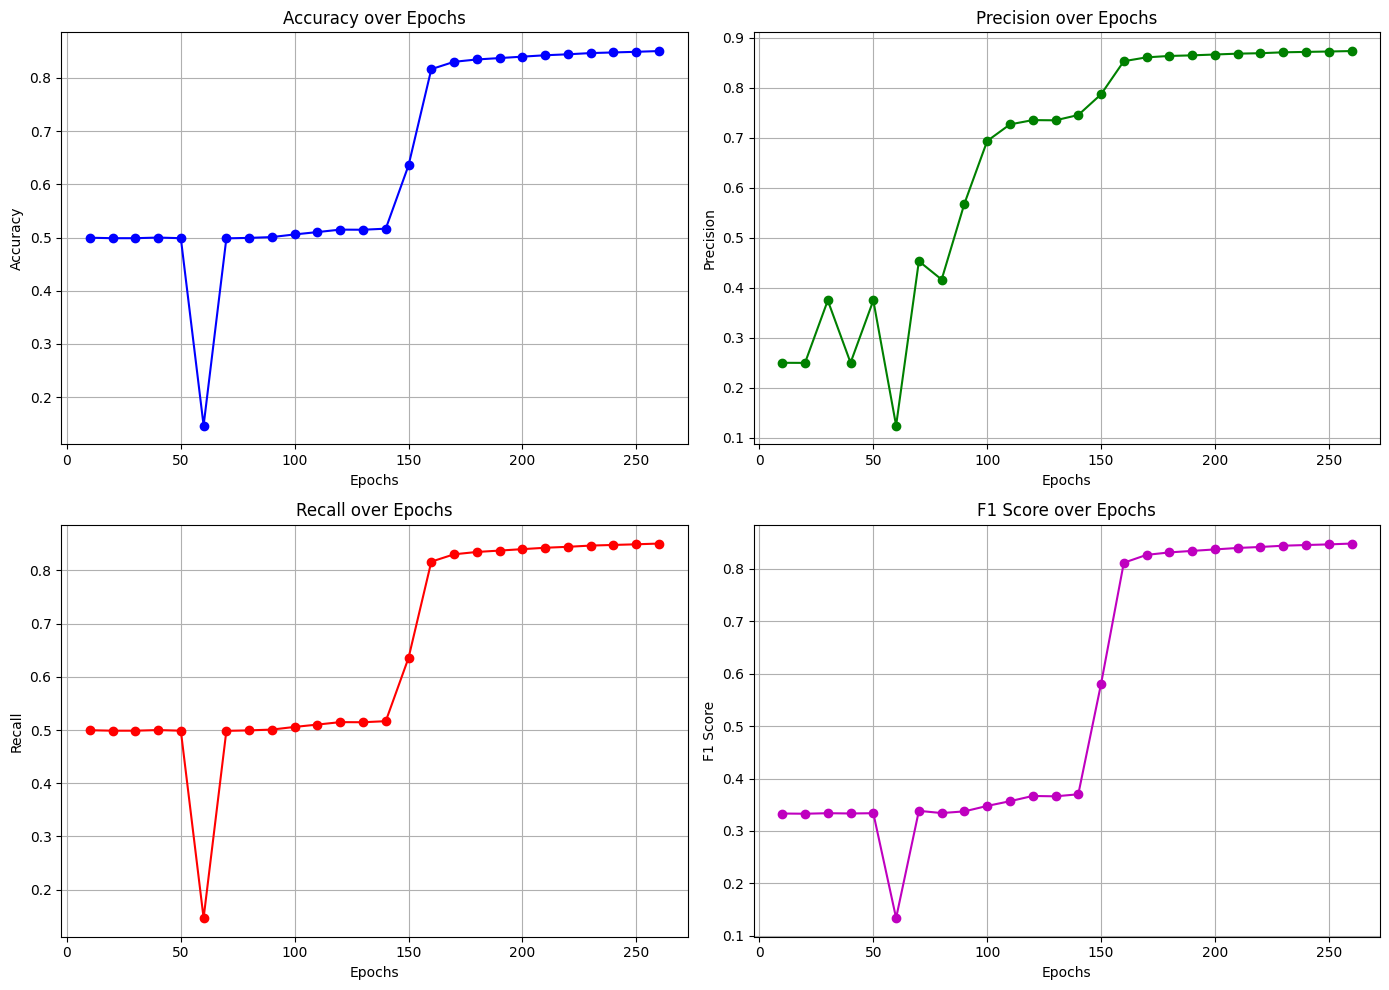

In [1]:
import matplotlib.pyplot as plt

# Data
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
          110, 120, 130, 140, 150, 160, 170, 180,
          190, 200, 210, 220, 230, 240, 250, 260]
accuracy = [0.4997, 0.4988, 0.4988, 0.5000, 0.4988, 0.1468,
            0.4985, 0.4994, 0.5009, 0.5059, 0.5103, 0.5149,
            0.5147, 0.5167, 0.6357, 0.8165, 0.8303, 0.8347,
            0.8373, 0.8400, 0.8426, 0.8444, 0.8467, 0.8479,
            0.8491, 0.8505]
precision = [0.2499, 0.2497, 0.3747, 0.2500, 0.3747, 0.1244,
             0.4533, 0.4165, 0.5684, 0.6938, 0.7270, 0.7356,
             0.7352, 0.7458, 0.7872, 0.8535, 0.8612, 0.8640,
             0.8652, 0.8669, 0.8686, 0.8695, 0.8713, 0.8721,
             0.8729, 0.8738]
recall = [0.4997, 0.4988, 0.4988, 0.5000, 0.4988, 0.1468,
          0.4985, 0.4994, 0.5009, 0.5059, 0.5103, 0.5149,
          0.5147, 0.5167, 0.6357, 0.8165, 0.8303, 0.8347,
          0.8373, 0.8400, 0.8426, 0.8444, 0.8467, 0.8479,
          0.8491, 0.8505]
f1_score = [0.3332, 0.3328, 0.3338, 0.3333, 0.3338, 0.1339,
            0.3383, 0.3341, 0.3373, 0.3477, 0.3567, 0.3667,
            0.3660, 0.3699, 0.5804, 0.8116, 0.8266, 0.8313,
            0.8342, 0.8370, 0.8398, 0.8417, 0.8441, 0.8454,
            0.8466, 0.8482]

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, marker='o', color='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, precision, marker='o', color='g')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, recall, marker='o', color='r')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, f1_score, marker='o', color='m')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()
